In [1]:
pip install pytorch_lightning

     |████████████████████████████████| 1.0 MB 5.1 MB/s 
     |████████████████████████████████| 329 kB 58.5 MB/s 
     |████████████████████████████████| 829 kB 34.1 MB/s 
     |████████████████████████████████| 132 kB 54.7 MB/s 
     |████████████████████████████████| 596 kB 52.6 MB/s 
     |████████████████████████████████| 1.1 MB 33.0 MB/s 
     |████████████████████████████████| 160 kB 55.2 MB/s 
     |████████████████████████████████| 271 kB 55.9 MB/s 
     |████████████████████████████████| 192 kB 58.8 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=ccfe55b3e0bf5c62cc16a287511472578dd53f14d23e6d34c4d7ae01df2b60a3
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
Successfully built future
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: future
    Found exis

In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import os

import pytorch_lightning as pl
import time
import copy
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F

from sklearn import decomposition
import scipy
from scipy.integrate import solve_ivp

from sklearn.feature_extraction import image

from utils import *

In [3]:
!pip install torchviz
import torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=879ae5de270e42984bdceb89c7911a3ed86b02a9342cb5412f52a565d3475ff9
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


# L63 Data simulation

Training dataset: 10000x3x200
Test dataset    : 2000x3x200


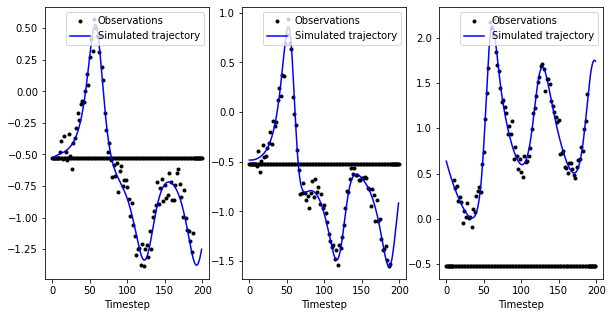

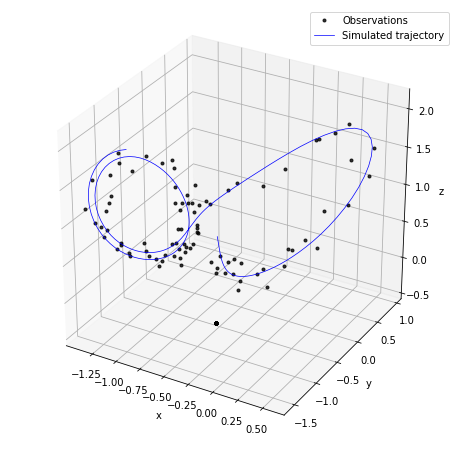

In [4]:
## data generation: L63 series
SD = Simulation_data()    
y0 = np.array([8.0,0.0,30.0])
tt = np.arange(SD.dt_integration,SD.nb_loop_test*SD.dt_integration+0.000001,SD.dt_integration)
S = solve_ivp(fun=lambda t,y: AnDA_Lorenz_63(y,t,SD.parameters.sigma,SD.parameters.rho,SD.parameters.beta),t_span=[0.,5+0.000001],y0=y0,first_step=SD.dt_integration,t_eval=np.arange(0,5+0.000001,SD.dt_integration),method='RK45')

y0 = S.y[:,-1];
S = solve_ivp(fun=lambda t,y: AnDA_Lorenz_63(y,t,SD.parameters.sigma,SD.parameters.rho,SD.parameters.beta),t_span=[SD.dt_integration,SD.nb_loop_test+0.000001],y0=y0,first_step=SD.dt_integration,t_eval=tt,method='RK45')
S = S.y.transpose()
  
xt = time_series()
xt.values = S
xt.time   = tt

#Data Extraction
x_train, x_val, x_test, x_train_obs, x_val_obs,x_test_obs, x_train_missing, x_val_missing,x_test_missing, mask_train,mask_val, mask_test  =  L63PatchDataExtraction(xt=xt,RMD=0.5)

print('Training dataset: %dx%dx%d'%(x_train.shape[0],x_train.shape[1],x_train.shape[2]))
print('Test dataset    : %dx%dx%d'%(x_test.shape[0],x_test.shape[1],x_test.shape[2]))

#Data Visualisation
visualisation_data(x_train,x_train_obs,180)

# CNN architecture

In [24]:
shapeData  = x_train.shape[1:]
dW = 1
dimCNN = 10
class CNN(pl.LightningModule):

    def __init__(self):
          super(CNN, self).__init__()
          self.conv1  = torch.nn.Conv1d(shapeData[0],shapeData[0]*dimCNN,2*dW+1,padding=dW,bias=False)
          self.conv2  = torch.nn.Conv1d(shapeData[0]*dimCNN,shapeData[0]*dimCNN,2*dW+1,padding=dW,bias=False)
          self.conv3  = torch.nn.Conv1d(shapeData[0]*dimCNN,shapeData[0]*dimCNN,2*dW+1,padding=dW,bias=False)
          self.conv4  = torch.nn.Conv1d(shapeData[0]*dimCNN,shapeData[0]*dimCNN,1,padding=0,bias=False)
          self.conv5  = torch.nn.Conv1d(shapeData[0]*dimCNN,shapeData[0],1,padding=0,bias=False)

    def forward(self, xinp):
          
          x = self.conv1( xinp )
          x = self.conv2( F.relu(x) )
          x = self.conv3( F.relu(x) )
          x = self.conv4( F.relu(x) )
          x = self.conv5( F.relu(x) )
          x = x.view(-1,shapeData[0],shapeData[1])

          return x
    
    def loss(self, x, y):

          return torch.mean((x - y)**2 )
    
    def training_step(self, train_batch, batch_idx):
      x,_,_,y  = train_batch
      
      outputs     = self.forward(x)
      
      train_loss    = self.loss(x,y)
      
      self.log('train_loss', train_loss)
      return train_loss

    def validation_step(self, train_batch, batch_idx):
      x,_,_,y  = train_batch
      
      outputs     = self.forward(x)
      
      val_loss    = self.loss(x,y)
      self.log('val_loss', val_loss)
      return val_loss


    def configure_optimizers(self):
      optimizer      = optim.Adam(model_CNN.parameters(), lr=1e-2)
      return optimizer


model_CNN           = CNN()

print(model_CNN)
print('CNN : Number of trainable parameters = %d'%(sum(p.numel() for p in model_CNN.parameters() if p.requires_grad)))


CNN(
  (conv1): Conv1d(3, 30, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  (conv2): Conv1d(30, 30, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  (conv3): Conv1d(30, 30, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
  (conv4): Conv1d(30, 30, kernel_size=(1,), stride=(1,), bias=False)
  (conv5): Conv1d(30, 3, kernel_size=(1,), stride=(1,), bias=False)
)
CNN : Number of trainable parameters = 6660


Epoch 0/19
Train Loss: 0.0643 
Epoch 1/19
Train Loss: 0.0469 
Epoch 2/19
Train Loss: 0.0327 
Epoch 3/19
Train Loss: 0.0335 
Epoch 4/19
Train Loss: 0.0256 
Epoch 5/19
Train Loss: 0.0261 
Epoch 6/19
Train Loss: 0.0267 
Epoch 7/19
Train Loss: 0.0215 
Epoch 8/19
Train Loss: 0.0267 
Epoch 9/19
Train Loss: 0.0254 
Epoch 10/19
Train Loss: 0.0255 
Epoch 11/19
Train Loss: 0.0248 
Epoch 12/19
Train Loss: 0.0236 
Epoch 13/19
Train Loss: 0.0203 
Epoch 14/19
Train Loss: 0.0224 
Epoch 15/19
Train Loss: 0.0240 
Epoch 16/19
Train Loss: 0.0207 
Epoch 17/19
Train Loss: 0.0229 
Epoch 18/19
Train Loss: 0.0203 
Epoch 19/19
Train Loss: 0.0221 


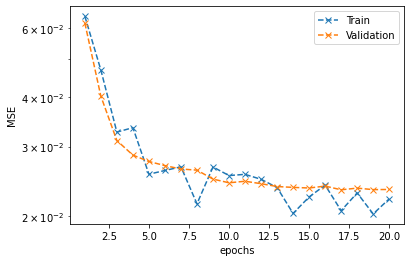

Training complete in 1m 55s
Best val loss: 0.020266


In [25]:
batch_size=128
training_dataset     = torch.utils.data.TensorDataset(torch.Tensor(x_train_missing),torch.Tensor(x_train_obs),torch.Tensor(mask_train),torch.Tensor(x_train)) # create your datset
val_dataset          = torch.utils.data.TensorDataset(torch.Tensor(x_val_missing),torch.Tensor(x_val_obs),torch.Tensor(mask_val),torch.Tensor(x_val)) # create your datset
test_dataset         = torch.utils.data.TensorDataset(torch.Tensor(x_test_missing),torch.Tensor(x_test_obs),torch.Tensor(mask_test),torch.Tensor(x_test)) # create your datset
dataloaders = {
    'train': torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True, num_workers=1),
    'val': torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=1),
    'test': torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=1)}

since = time.time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_model_CNN_wts = copy.deepcopy(model_CNN.state_dict())
best_loss         = 1e10

optimizer      = optim.Adam(model_CNN.parameters(), lr=1e-3)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)


num_epochs = 20
tot_loss=[]
tot_val_loss=[]
for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    for phase in ['train','val']:
        if phase == 'train':
          model_CNN.train()
        else:
          model_CNN.eval()   # Set model to evaluate mode

        running_loss = 0.0
        num_loss     = 0

        running_val_loss = 0.0
        num_val_loss     = 0
        for inputs_init,inputs_missing,masks,targets_GT in dataloaders[phase]:
            inputs_missing    = inputs_missing.to(device)
            optimizer.zero_grad()
      
            with torch.set_grad_enabled(True): 
            
                outputs = model_CNN(inputs_missing)
                
                loss      = torch.mean((outputs - targets_GT)**2 )
                
                # backward + optimize only if in training phase
                if phase == 'train':
                  loss.backward()
                  optimizer.step()
                  
            
            
        if phase == 'train':
            exp_lr_scheduler.step()
            running_loss             += loss.item() * inputs_missing.size(0)
            num_loss                 += inputs_missing.size(0)
            epoch_loss       = running_loss / num_loss
            tot_loss.append(epoch_loss)
            print('Train Loss: {:.4f} '.format(epoch_loss))
        
        else :
            running_val_loss             += loss.item() * inputs_missing.size(0)
            num_val_loss                 += inputs_missing.size(0)
            epoch_val_loss       = running_val_loss / num_val_loss
            tot_val_loss.append(epoch_val_loss)
            
        
        
        if phase == 'val' and epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model_CNN.state_dict())



plt.semilogy(np.arange(1,num_epochs+1,1),tot_loss,'x--',label='Train')
plt.semilogy(np.arange(1,num_epochs+1,1),tot_val_loss,'x--',label='Validation')
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Best val loss: {:4f}'.format(best_loss))

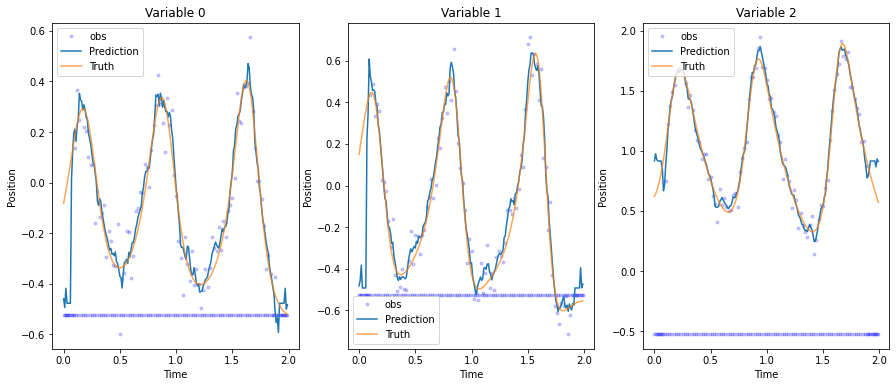

In [32]:
test= next(iter(dataloaders['test']))

x_pred=model_CNN(test[1])

idx=25
x_obs=test[1][idx].detach().numpy()
x_pred=x_pred[idx].detach().numpy()
x_truth=test[3][idx].detach().numpy()


time_=np.arange(0,2,0.01)

plt.figure(figsize=(15,6))
for j in range(3):
  plt.subplot(1,3,j+1)
  plt.plot(time_,x_obs[j],'b.',alpha=0.2,label='obs')
  plt.plot(time_,x_pred[j],alpha=1,label='Prediction')
  plt.plot(time_,x_truth[j],alpha=0.7,label='Truth')
  plt.xlabel('Time')
  plt.ylabel('Position')
  plt.title('Variable {}'.format(j))
  plt.legend()
plt.savefig('Prediction.pdf')